In [204]:
import math as m
import numpy as np
import scipy.optimize as o

import pandas as pd
import matplotlib.pyplot as plt

In [190]:
### PARAM: Initial player or pearl position
s_x0 = 0
s_y0 = 4
s_z0 = 0

s_y0 = s_y0 + 1.62 - 0.1

In [ ]:
### PARAM: Initial player velocity
v_px = 0
v_py = 0
v_pz = 0

In [191]:
### Initial velocity at desired axis given a pitch. Yaw is kept constant to 360 degrees. 
def v_0(axis:str, pitch:float) -> float:
    pitch = m.radians(pitch)
    return {
        "x": 0,
        "y": -1.5 * m.sin(pitch),
        "z": 1.5 * m.cos(pitch)
    }[axis]

In [192]:
### Component-wise velocity function given axis, initial pitch, and time. We keep yaw constant at 360 degrees
def v(t:int, axis:str, pitch:float) -> float:
    pitch = m.radians(pitch)
    return {
        "x": v_0(axis, pitch)*0.99**m.floor(t), 
        "y": v_0(axis, pitch)*0.99**m.floor(t) - 0.03*(100-100*0.99**m.floor(t)),
        "z": v_0(axis, pitch)*0.99**m.floor(t)
    }[axis]

In [193]:
### Component-wise position function. We keep yaw constant at 360 degrees (hence, zeroing every sin(yaw))
def s(t:int, axis:str, pitch:float) -> float:
    pitch = m.radians(pitch)
    return {
        "x": s_x0,
        "y": s_y0 - 3*t - (1.5*m.sin(pitch) - 3) * (100 - 100*0.99**t),
        "z": s_z0 + 1.5*m.cos(pitch) * (100 - 100*0.99**t)
    }[axis]

In [194]:
### Passed into root_scalar to find where the position function for y, ie s_y, intersects the even ground y=s_y0. This helper transforms the root found by root_scalar to be the solution to s_y = s_y0 (where s_y0 is adjusted for the 1.62 and -0.1 offsets applied its initialization). 
def helper_s_y(t:int, pitch:float) -> float:
    return s(t, "y", pitch) - (s_y0 - (1.62-0.1))

In [196]:
### Compute when the pearl hits the ground, ASSUMING the landing spot is level with the player's standing spot 
# upper bound seems to be at least 90 ticks, as produced by angle -89 to -84 (angle -83 produced 89 ticks). Hence, 300 as an upper bound on root-finding is more than enough.  
def compute_landing_time(pitch:float) -> float:
    return m.floor(o.root_scalar(helper_s_y, args=(pitch), bracket=[0, 300], method="bisect").root)

In [290]:
landing_times = {}
landing_spots_z = {}
grain = 0.1  #0.00000001: -37.98 to -37.973683
for pitch in np.arange(-90, 0.001, grain):
    landing_times[pitch] = (compute_landing_time(pitch))
    landing_spots_z[pitch] = s(landing_times[pitch], "z", pitch)
landing_spots_z, len(landing_spots_z)

({-90.0: 5.429898608354366e-15,
  -89.9: 0.15477043783906672,
  -89.80000000000001: 0.3095404042205333,
  -89.70000000000002: 0.4643094276882467,
  -89.60000000000002: 0.6190770367889208,
  -89.50000000000003: 0.7738427600735774,
  -89.40000000000003: 0.9286061260989835,
  -89.30000000000004: 1.0833666634290868,
  -89.20000000000005: 1.2381239006364502,
  -89.10000000000005: 1.3928773663036915,
  -89.00000000000006: 1.547626589024916,
  -88.90000000000006: 1.7023710974071535,
  -88.80000000000007: 1.8571104200717956,
  -88.70000000000007: 2.011844085656029,
  -88.60000000000008: 2.166571622814274,
  -88.50000000000009: 2.32129256021962,
  -88.40000000000009: 2.4760064265652777,
  -88.3000000000001: 2.63071275056594,
  -88.2000000000001: 2.785411060959333,
  -88.10000000000011: 2.9401008865075764,
  -88.00000000000011: 3.0947817559986333,
  -87.90000000000012: 3.24945319824775,
  -87.80000000000013: 3.4041147420988906,
  -87.70000000000013: 3.558765916426169,
  -87.60000000000014: 3.713

In [291]:
df = pd.DataFrame.from_dict(landing_spots_z, orient='index').reset_index()
df.columns = columns=['Pitch', 'Distance']
df['Pitch'] = df['Pitch'].round(1)
df['Distance'] = df['Distance'].apply(lambda x: '{:.6f}'.format(x)).astype(float)
pd.options.display.float_format = None
df = df.reset_index(drop = True)
df

,Pitch,Distance
0,-90.0,0.000000
1,-89.9,0.154770
2,-89.8,0.309540
3,-89.7,0.464309
4,-89.6,0.619077
...,...,...
896,-0.4,15.698879
897,-0.3,15.699047
898,-0.2,14.342601
899,-0.1,14.342667


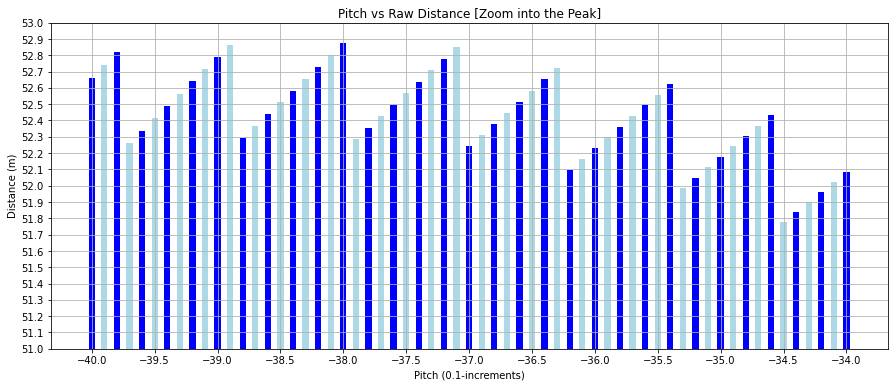

In [383]:
plt.figure(figsize=(15,6))
zoomed_df = df[(df['Pitch'] >= -40.) & (df['Pitch'] <= -34.)]

plt.bar(zoomed_df['Pitch'], zoomed_df['Distance'], color=['blue', 'lightblue'], width=0.05)
plt.xticks(np.arange(-40, -34+0.1, 0.5))
plt.yticks(np.arange(51, 53+0.1, 0.1))
plt.ylim(51, 53)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Distance (m)')
plt.title('Pitch vs Raw Distance [Zoom into the Peak]')
plt.grid(True)

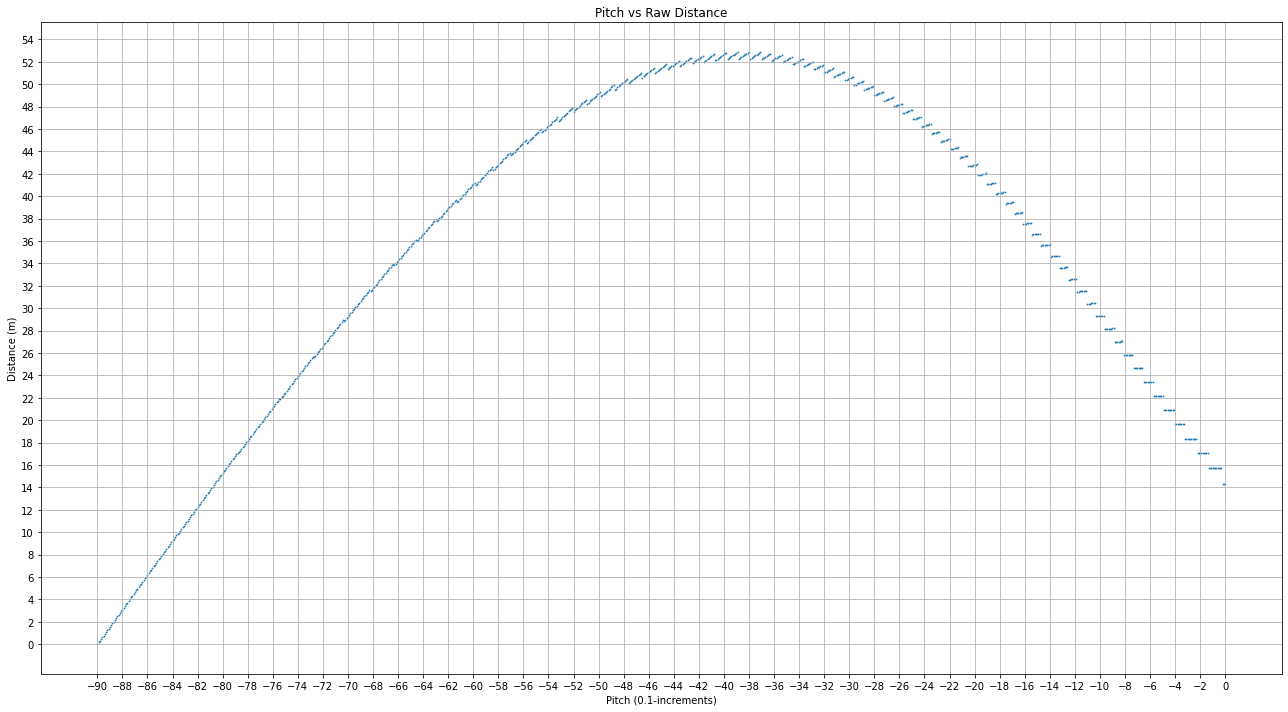

In [382]:
plt.figure(figsize=(18,10))

plt.scatter(df['Pitch'], df['Distance'], s=0.6)
plt.xticks(np.arange(-90, 0+0.1, 2))
plt.yticks(np.arange(0, 54+0.1, 2))
#plt.ylim(51, 53)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Distance (m)')
plt.title('Pitch vs Raw Distance')
plt.grid(True)
plt.tight_layout()
#plt.margins(x=0)

In [340]:
# Generated with np.arange(-37.98, -37.973683, 0.00000001)
top_10_entries = dict(sorted(landing_spots_z.items(), key=lambda item: item[1], reverse=True)[:10])
top_10_entries

{-38.000000000002956: 52.87353453929898,
 -38.900000000002905: 52.86333606223416,
 -37.10000000000301: 52.84797430681801,
 -39.80000000000285: 52.81737071275037,
 -38.10000000000295: 52.80135565843101,
 -39.0000000000029: 52.78880798079306,
 -37.200000000003: 52.77813546764518,
 -39.90000000000285: 52.74048574126374,
 -38.200000000002944: 52.72901593547663,
 -36.30000000000305: 52.719171113428075}

In [285]:
### Increments of 0.1 and of zoomed graph -- plotting landing times
landing_times_2 = {}
for pitch in np.arange(-40, -34, 0.1):
    landing_times_2[pitch] = compute_landing_time(pitch)

tf = pd.DataFrame.from_dict(landing_times_2, orient='index').reset_index()
tf.columns = columns=['Pitch', 'Airtime']
tf['Pitch'] = tf['Pitch'].round(1)
#tf['Airtime'] = df['Airtime'].apply(lambda x: '{:.6f}'.format(x)).astype(float)
pd.options.display.float_format = None
tf = tf.reset_index(drop = True)
tf.describe()

,Pitch,Airtime
count,60.000000,60.000000
mean,-37.050000,57.433333
std,1.746425,2.053246
min,-40.000000,54.000000
25%,-38.525000,56.000000
50%,-37.050000,57.500000
75%,-35.575000,59.000000
max,-34.100000,61.000000


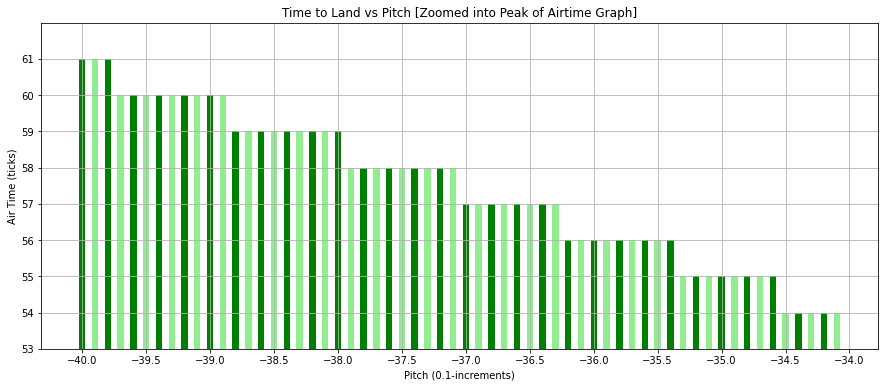

In [381]:
plt.figure(figsize=(15,6))

plt.bar(tf['Pitch'], tf['Airtime'], color=['green', 'lightgreen'], width=0.05)
plt.xticks(np.arange(-40, -34+0.1, 0.5))
plt.yticks(np.arange(53, 62, 1))
plt.ylim(53, 62)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Air Time (ticks)')
plt.title('Time to Land vs Pitch [Zoomed into Peak of Airtime Graph]')
plt.grid(True)


In [367]:
### Increments of 0.1 and of zoomed graph -- plotting landing times
landing_times_3 = {}
for pitch in np.arange(-90, 0+0.1, 0.1):
    landing_times_3[pitch] = compute_landing_time(pitch)

tf_2 = pd.DataFrame.from_dict(landing_times_3, orient='index').reset_index()
tf_2.columns = columns=['Pitch', 'Airtime']
tf_2['Pitch'] = tf_2['Pitch'].round(1)
#tf['Airtime'] = df['Airtime'].apply(lambda x: '{:.6f}'.format(x)).astype(float)
pd.options.display.float_format = None
tf_2 = tf_2.reset_index(drop = True)
tf_2.describe()

,Pitch,Airtime
count,901.000000,901.000000
mean,-45.000000,59.921199
std,26.024059,24.892645
min,-90.000000,10.000000
25%,-67.500000,39.000000
50%,-45.000000,66.000000
75%,-22.500000,83.000000
max,-0.000000,89.000000


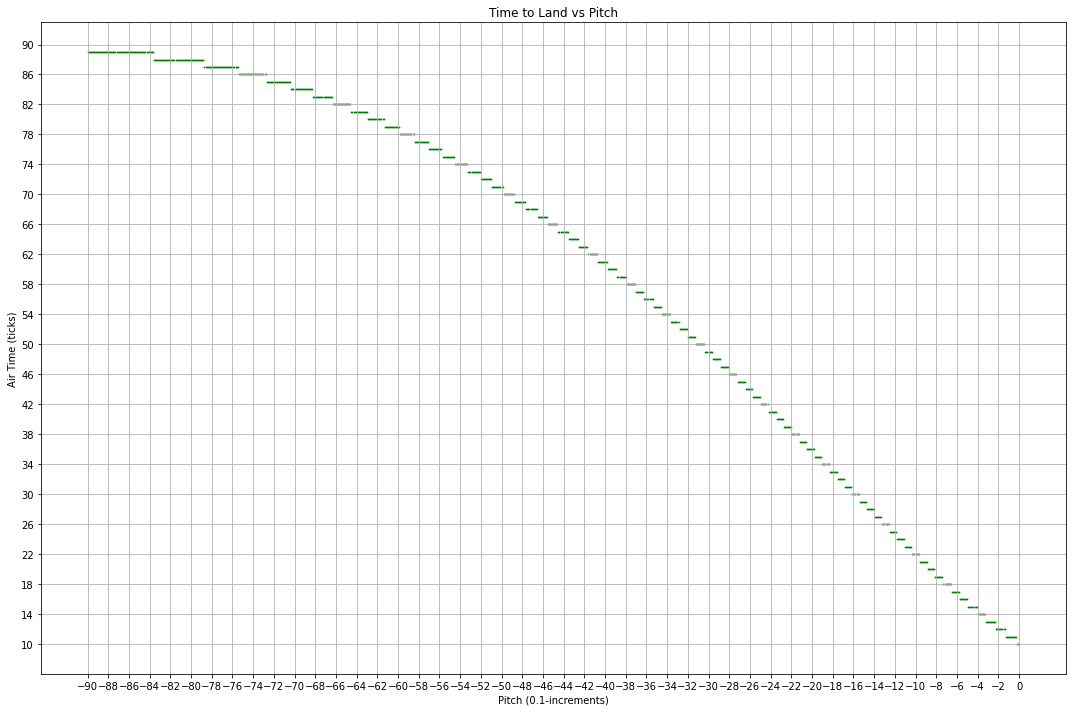

In [380]:
plt.figure(figsize=(15,10))

plt.scatter(tf_2['Pitch'], tf_2['Airtime'], color=['green'], s=0.6)
plt.xticks(np.arange(-90, 0+0.1, 2))
plt.yticks(np.arange(10, 90+1, 4))
#plt.ylim(53, 62)
plt.xlabel('Pitch (0.1-increments)')
plt.ylabel('Air Time (ticks)')
plt.title('Time to Land vs Pitch')
plt.grid(True)
plt.tight_layout()


In [343]:
### Now generate the float-precise dataset
landing_times_f = {}
landing_spots_z_f = {}
grain = 0.00000001 #0.00000001: -37.98 to -37.973683
for pitch in np.arange(-37.98, -37.973683, grain):
    landing_times_f[pitch] = (compute_landing_time(pitch))
    landing_spots_z_f[pitch] = s(landing_times_f[pitch], "z", pitch)
landing_spots_z_f, len(landing_spots_z_f)

({-37.98: 52.88795099506719,
  -37.979999989999996: 52.88795100227382,
  -37.979999979999995: 52.88795100948043,
  -37.979999969999994: 52.88795101668706,
  -37.979999959999994: 52.88795102389366,
  -37.97999994999999: 52.88795103110029,
  -37.97999993999999: 52.8879510383069,
  -37.97999992999999: 52.88795104551353,
  -37.97999991999999: 52.88795105272014,
  -37.97999990999999: 52.88795105992676,
  -37.97999989999999: 52.88795106713337,
  -37.97999988999999: 52.88795107434,
  -37.97999987999999: 52.88795108154661,
  -37.979999869999986: 52.88795108875324,
  -37.979999859999985: 52.88795109595984,
  -37.979999849999984: 52.887951103166465,
  -37.979999839999984: 52.88795111037308,
  -37.97999982999998: 52.887951117579696,
  -37.97999981999998: 52.88795112478632,
  -37.97999980999998: 52.887951131992935,
  -37.97999979999998: 52.88795113919955,
  -37.97999978999998: 52.88795114640617,
  -37.97999977999998: 52.88795115361279,
  -37.97999976999998: 52.887951160819405,
  -37.97999975999998

In [353]:
top_entries_f = dict(sorted(landing_spots_z_f.items(), key=lambda item: item[1], reverse=True)[:100])
top_entries_f

{-37.97368379947739: 52.89250251748429,
 -37.97368380947739: 52.892502510278696,
 -37.973683819477394: 52.892502503073075,
 -37.973683829477395: 52.89250249586748,
 -37.973683839477395: 52.89250248866189,
 -37.973683849477396: 52.89250248145628,
 -37.9736838594774: 52.89250247425069,
 -37.9736838694774: 52.892502467045084,
 -37.9736838794774: 52.89250245983949,
 -37.9736838894774: 52.892502452633885,
 -37.9736838994774: 52.89250244542828,
 -37.9736839094774: 52.892502438222685,
 -37.9736839194774: 52.89250243101709,
 -37.9736839294774: 52.892502423811486,
 -37.973683939477404: 52.89250241660588,
 -37.973683949477405: 52.89250240940029,
 -37.973683959477405: 52.89250240219468,
 -37.973683969477406: 52.89250239498909,
 -37.97368397947741: 52.892502387783495,
 -37.97368398947741: 52.89250238057789,
 -37.97368399947741: 52.892502373372295,
 -37.97368400947741: 52.89250236616669,
 -37.97368401947741: 52.89250235896108,
 -37.97368402947741: 52.89250235175549,
 -37.97368403947741: 52.89250234

In [362]:
df_f = pd.DataFrame.from_dict(top_entries_f, orient='index').reset_index()
df_f.columns = columns=['Pitch', 'Distance']
pd.options.display.float_format = '{:.14f}'.format
df_f = df_f.reset_index(drop = True)
df_f['Rank'] = range(1, 100+1)
df_f = df_f[['Rank', 'Pitch', 'Distance']]
df_f

,Rank,Pitch,Distance
0,1,-37.97368379947739,52.89250251748429
1,2,-37.97368380947739,52.89250251027870
2,3,-37.97368381947739,52.89250250307308
3,4,-37.97368382947739,52.89250249586748
4,5,-37.97368383947740,52.89250248866189
...,...,...,...
95,96,-37.97368474947747,52.89250183295229
96,97,-37.97368475947747,52.89250182574668
97,98,-37.97368476947747,52.89250181854108
98,99,-37.97368477947747,52.89250181133549


In [385]:
### Write data to an excel with multiple tabs
with pd.ExcelWriter('pitch-vs-distance-results.xlsx', engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='0.1-grain', index=False)
    df_f.to_excel(writer, sheet_name='0.00000001-grain-top-100', index=False)

with pd.ExcelWriter('pitch-vs-airtime-results-zoomed-in.xlsx', engine='openpyxl') as writer:
    tf_2.to_excel(writer, sheet_name='pitch-vs-airtime', index=False)